In [1]:
print('')

NameError: name 'criterion' is not defined

Epoch 0/9
train Loss: 1.8771 Acc: 0.3264 Recall: 0.3349
val Loss: 1.8619 Acc: 0.3400 Recall: 0.3513

Epoch 1/9
train Loss: 1.7157 Acc: 0.3864 Recall: 0.3952
val Loss: 1.7458 Acc: 0.3768 Recall: 0.3984

Epoch 2/9
train Loss: 1.6753 Acc: 0.4009 Recall: 0.4077
val Loss: 1.7426 Acc: 0.3594 Recall: 0.3821

Epoch 3/9
train Loss: 1.6575 Acc: 0.4084 Recall: 0.4154
val Loss: 1.8182 Acc: 0.3631 Recall: 0.3795

Epoch 4/9
train Loss: 1.6366 Acc: 0.4157 Recall: 0.4234
val Loss: 1.5969 Acc: 0.4327 Recall: 0.4397

Epoch 5/9
train Loss: 1.6324 Acc: 0.4175 Recall: 0.4253
val Loss: 1.6129 Acc: 0.4163 Recall: 0.4297

Epoch 6/9
train Loss: 1.6325 Acc: 0.4148 Recall: 0.4222
val Loss: 1.8200 Acc: 0.3700 Recall: 0.3710

Epoch 7/9
train Loss: 1.6301 Acc: 0.4184 Recall: 0.4262
val Loss: 1.5250 Acc: 0.4605 Recall: 0.4639

Epoch 8/9
train Loss: 1.6284 Acc: 0.4175 Recall: 0.4246
val Loss: 2.0690 Acc: 0.2804 Recall: 0.2735

Epoch 9/9
train Loss: 1.6296 Acc: 0.4183 Recall: 0.4255
val Loss: 1.6293 Acc: 0.4148 Recall

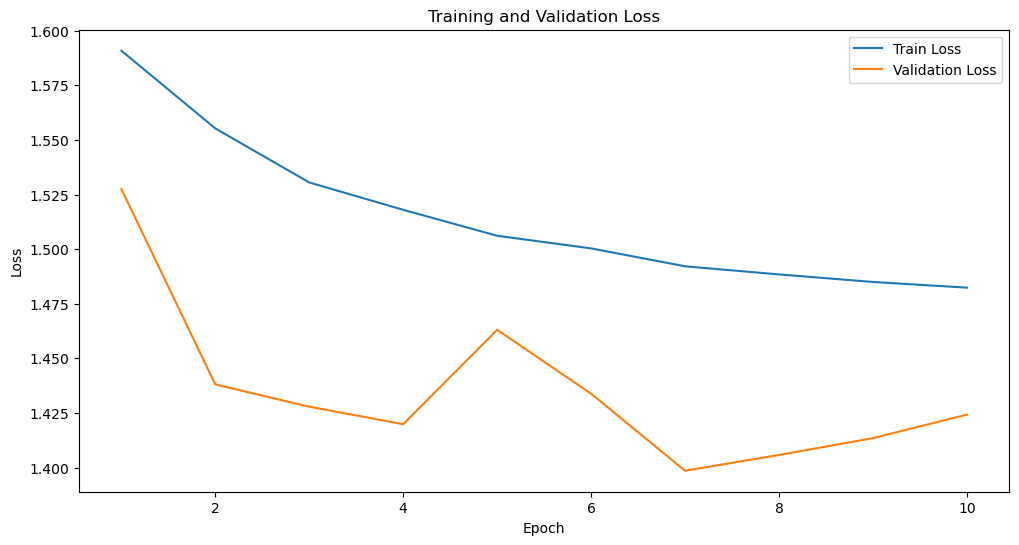

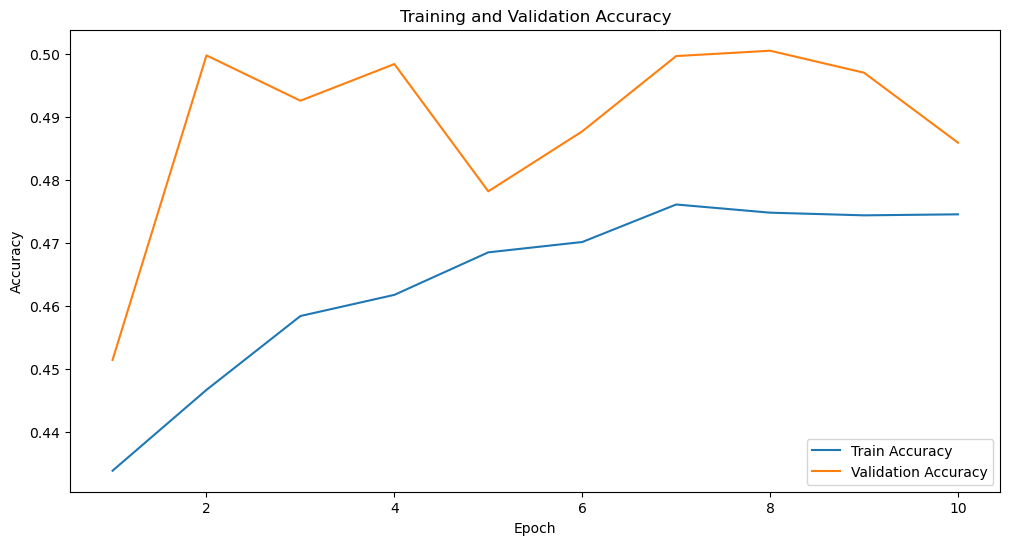

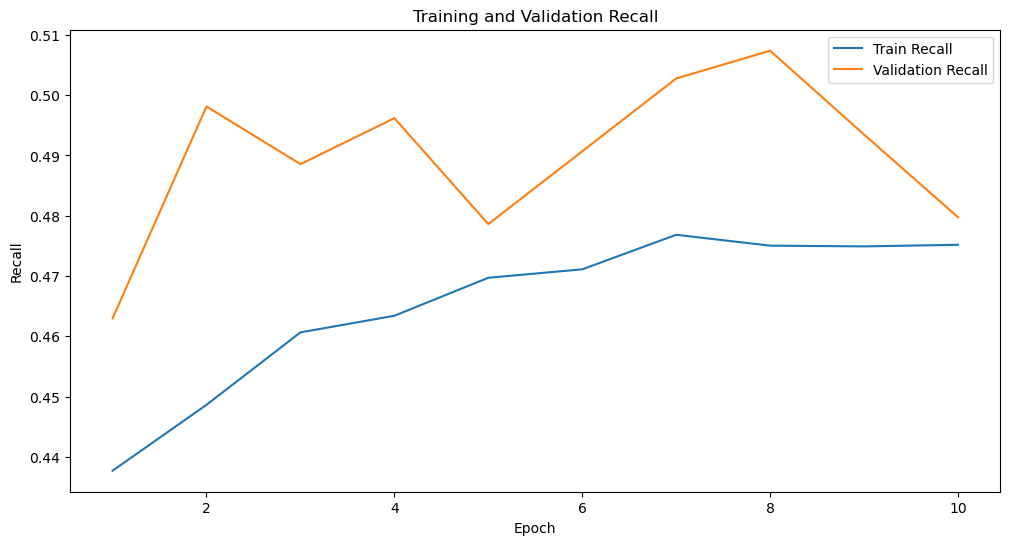

In [7]:
import os  # os 모듈 추가
import time
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, confusion_matrix
import seaborn as sns

# 데이터 전처리
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './final'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# MobileNet 모델 불러오기 및 수정
model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

# 학습 및 평가 함수
def train_model(model, criterion, optimizer, start_epoch=0, num_epochs=10):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    train_recall_history = []
    val_recall_history = []
    
    for epoch in range(start_epoch, start_epoch + num_epochs):
        epoch_str = f'Epoch {epoch}/{start_epoch + num_epochs - 1}'
        print(epoch_str)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # GPU 메모리 정리
                del inputs, labels, outputs, preds
                torch.cuda.empty_cache()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_recall = recall_score(all_labels, all_preds, average='macro')
            
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
                train_recall_history.append(epoch_recall)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())
                val_recall_history.append(epoch_recall)
            
            log_str = f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Recall: {epoch_recall:.4f}'
            print(log_str)
        
        print()

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history, train_recall_history, val_recall_history

# Define the hyperparameter search space
learning_rate_range = [10 ** np.random.uniform(-4, -2) for _ in range(100)]
weight_decay_range = [10 ** np.random.uniform(-4, -2) for _ in range(100)]
dropout_range = [0.1, 0.2, 0.3, 0.4, 0.5]
num_epochs = 10  # Number of epochs

# Define the number of random search iterations
num_iterations = 10

# Initialize lists to store the results
train_losses = []
train_accuracies = []
best_train_loss = float('inf')
best_train_accuracy = 0
best_hyperparams = {}

# 손실 함수 및 최적화기 설정
criterion = nn.CrossEntropyLoss()

# Perform random search
for i in range(num_iterations):
    # Randomly sample hyperparameters from the search space
    learning_rate = random.choice(learning_rate_range)
    weight_decay = random.choice(weight_decay_range)
    dropout = random.choice(dropout_range)

    # Update the model's hyperparameters
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.p = dropout

    # Train the model for the specified number of epochs
    epoch_losses = []
    epoch_accuracies = []
    start_time = time.time()

    # Train model with current hyperparameters
    additional_model, additional_train_loss, additional_val_loss, additional_train_acc, additional_val_acc, additional_train_recall, additional_val_recall = train_model(model, criterion, optimizer, start_epoch=0, num_epochs=num_epochs)
    
    # Calculate the average train loss and accuracy over the epochs
    avg_train_loss = sum(additional_train_loss) / num_epochs
    avg_train_accuracy = sum(additional_train_acc) / num_epochs

    # Update the best hyperparameters and results
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        best_train_accuracy = avg_train_accuracy
        best_hyperparams = {
            'learning_rate': learning_rate,
            'weight_decay': weight_decay,
            'dropout': dropout
        }

    # Append the current iteration's results to the lists
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)
    print(f"Iteration {i+1}: Avg Train Loss: {avg_train_loss:.4f}, Avg Train Accuracy: {avg_train_accuracy:.2f}%")

print(f"Best hyperparameters: {best_hyperparams}")
print(f"Best train loss: {best_train_loss:.4f}, Best train accuracy: {best_train_accuracy:.2f}%")

# 시각화 업데이트
epochs = list(range(1, num_epochs + 1))

# 학습 및 검증 손실 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, additional_train_loss, label='Train Loss')
plt.plot(epochs, additional_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 학습 및 검증 정확도 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, additional_train_acc, label='Train Accuracy')
plt.plot(epochs, additional_val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# 학습 및 검증 리콜 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, additional_train_recall, label='Train Recall')
plt.plot(epochs, additional_val_recall, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.title('Training and Validation Recall')
plt.show()

# 혼동 행렬 시각화 업데이트
def evaluate_model_and_plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_preds)
    
    # 비율로 변환
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # 혼동 행렬 시각화 - 비율
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()

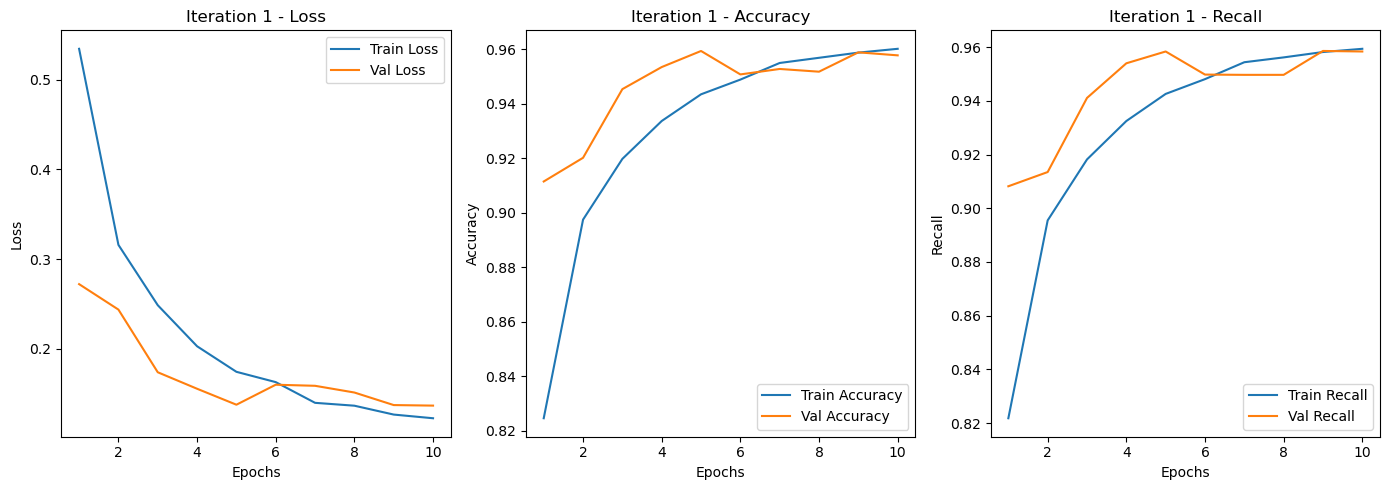

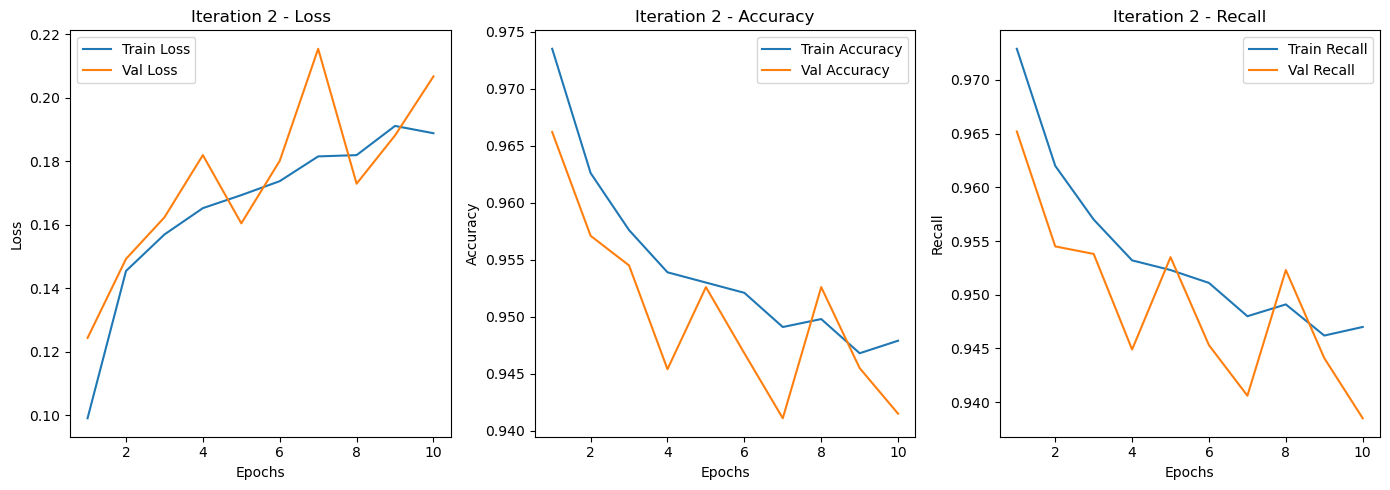

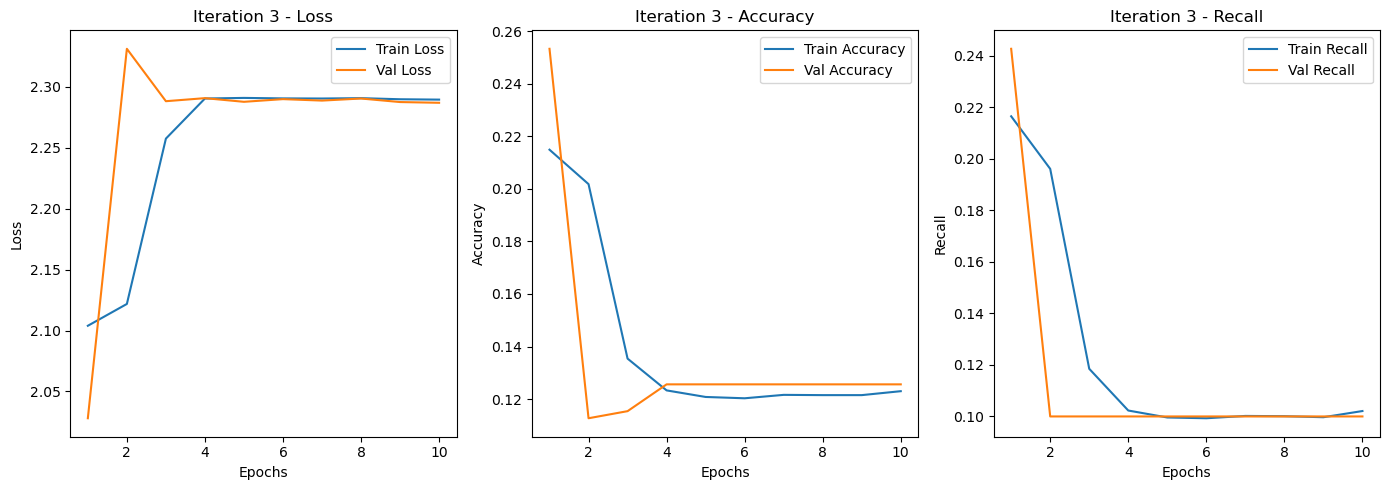

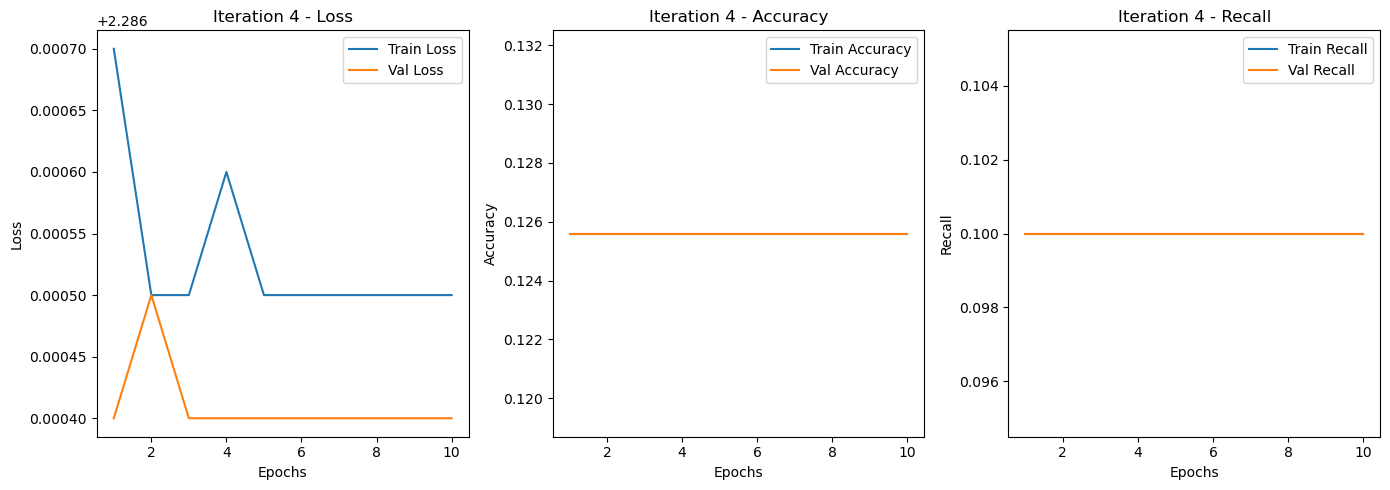

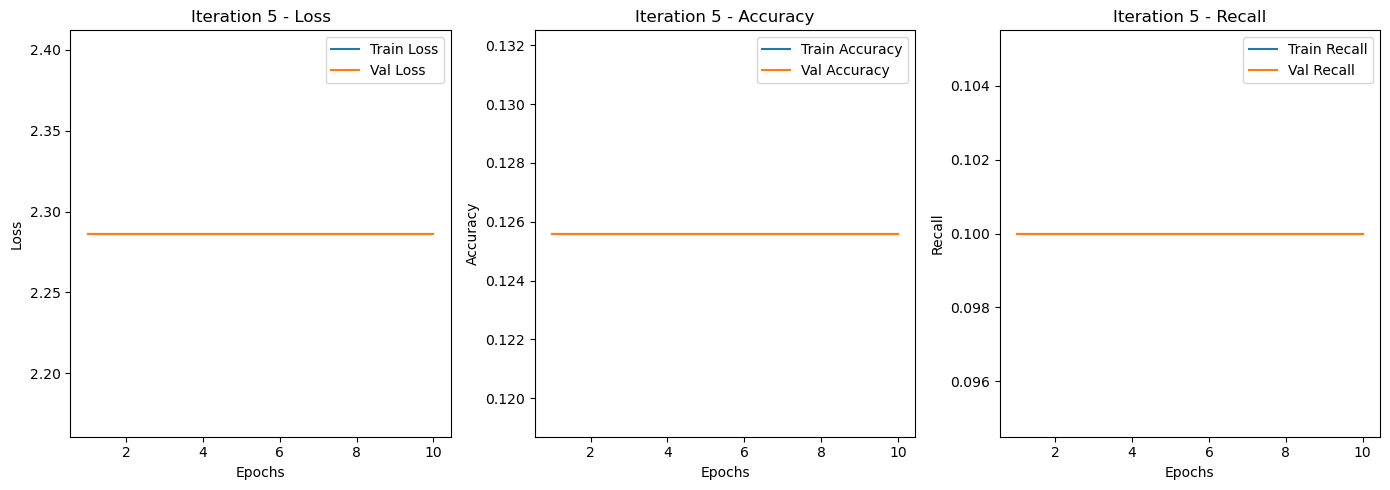

In [9]:
import matplotlib.pyplot as plt

# 이터레이션 데이터
iterations = [
    {
        "train_loss": [0.5345, 0.3158, 0.2485, 0.2027, 0.1742, 0.1627, 0.1396, 0.1364, 0.1265, 0.1224],
        "val_loss": [0.2720, 0.2436, 0.1737, 0.1553, 0.1375, 0.1598, 0.1586, 0.1511, 0.1371, 0.1365],
        "train_acc": [0.8246, 0.8975, 0.9198, 0.9337, 0.9435, 0.9489, 0.9550, 0.9569, 0.9588, 0.9602],
        "val_acc": [0.9115, 0.9202, 0.9454, 0.9535, 0.9594, 0.9508, 0.9528, 0.9518, 0.9589, 0.9578],
        "train_recall": [0.8218, 0.8955, 0.9182, 0.9325, 0.9426, 0.9481, 0.9544, 0.9562, 0.9582, 0.9594],
        "val_recall": [0.9082, 0.9135, 0.9411, 0.9540, 0.9584, 0.9498, 0.9497, 0.9497, 0.9586, 0.9584]
    },
    {
        "train_loss": [0.0990, 0.1454, 0.1569, 0.1652, 0.1693, 0.1737, 0.1815, 0.1819, 0.1911, 0.1888],
        "val_loss": [0.1243, 0.1492, 0.1623, 0.1819, 0.1604, 0.1801, 0.2154, 0.1729, 0.1881, 0.2067],
        "train_acc": [0.9735, 0.9626, 0.9576, 0.9539, 0.9530, 0.9521, 0.9491, 0.9498, 0.9468, 0.9479],
        "val_acc": [0.9662, 0.9571, 0.9545, 0.9454, 0.9526, 0.9468, 0.9411, 0.9526, 0.9455, 0.9415],
        "train_recall": [0.9729, 0.9620, 0.9570, 0.9532, 0.9523, 0.9511, 0.9480, 0.9491, 0.9462, 0.9470],
        "val_recall": [0.9652, 0.9545, 0.9538, 0.9449, 0.9535, 0.9453, 0.9406, 0.9523, 0.9441, 0.9385]
    },
    {
        "train_loss": [2.1039, 2.1218, 2.2575, 2.2904, 2.2909, 2.2905, 2.2904, 2.2907, 2.2898, 2.2895],
        "val_loss": [2.0280, 2.3312, 2.2882, 2.2907, 2.2877, 2.2899, 2.2887, 2.2904, 2.2875, 2.2869],
        "train_acc": [0.2149, 0.2018, 0.1354, 0.1233, 0.1208, 0.1203, 0.1216, 0.1215, 0.1215, 0.1230],
        "val_acc": [0.2533, 0.1127, 0.1154, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256],
        "train_recall": [0.2165, 0.1961, 0.1185, 0.1023, 0.0996, 0.0993, 0.1002, 0.1001, 0.0997, 0.1021],
        "val_recall": [0.2427, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000]
    },
    {
        "train_loss": [2.2867, 2.2865, 2.2865, 2.2866, 2.2865, 2.2865, 2.2865, 2.2865, 2.2865, 2.2865],
        "val_loss": [2.2864, 2.2865, 2.2864, 2.2864, 2.2864, 2.2864, 2.2864, 2.2864, 2.2864, 2.2864],
        "train_acc": [0.1256, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256],
        "val_acc": [0.1256, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256],
        "train_recall": [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
        "val_recall": [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000]
    },
    {
        "train_loss": [2.2864, 2.2864, 2.2864, 2.2864, 2.2864, 2.2864, 2.2864, 2.2864, 2.2864, 2.2864],
        "val_loss": [2.2864, 2.2864, 2.2864, 2.2864, 2.2864, 2.2864, 2.2864, 2.2864, 2.2864, 2.2864],
        "train_acc": [0.1256, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256],
        "val_acc": [0.1256, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256, 0.1256],
        "train_recall": [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
        "val_recall": [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000]
    }
]

def plot_metrics(iterations):
    epochs = range(1, 11)
    for i, iteration in enumerate(iterations):
        plt.figure(figsize=(14, 5))
        # Loss plot
        plt.subplot(1, 3, 1)
        plt.plot(epochs, iteration["train_loss"], label="Train Loss")
        plt.plot(epochs, iteration["val_loss"], label="Val Loss")
        plt.title(f"Iteration {i+1} - Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        
        # Accuracy plot
        plt.subplot(1, 3, 2)
        plt.plot(epochs, iteration["train_acc"], label="Train Accuracy")
        plt.plot(epochs, iteration["val_acc"], label="Val Accuracy")
        plt.title(f"Iteration {i+1} - Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        
        # Recall plot
        plt.subplot(1, 3, 3)
        plt.plot(epochs, iteration["train_recall"], label="Train Recall")
        plt.plot(epochs, iteration["val_recall"], label="Val Recall")
        plt.title(f"Iteration {i+1} - Recall")
        plt.xlabel("Epochs")
        plt.ylabel("Recall")
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Plot the metrics for all iterations
plot_metrics(iterations)


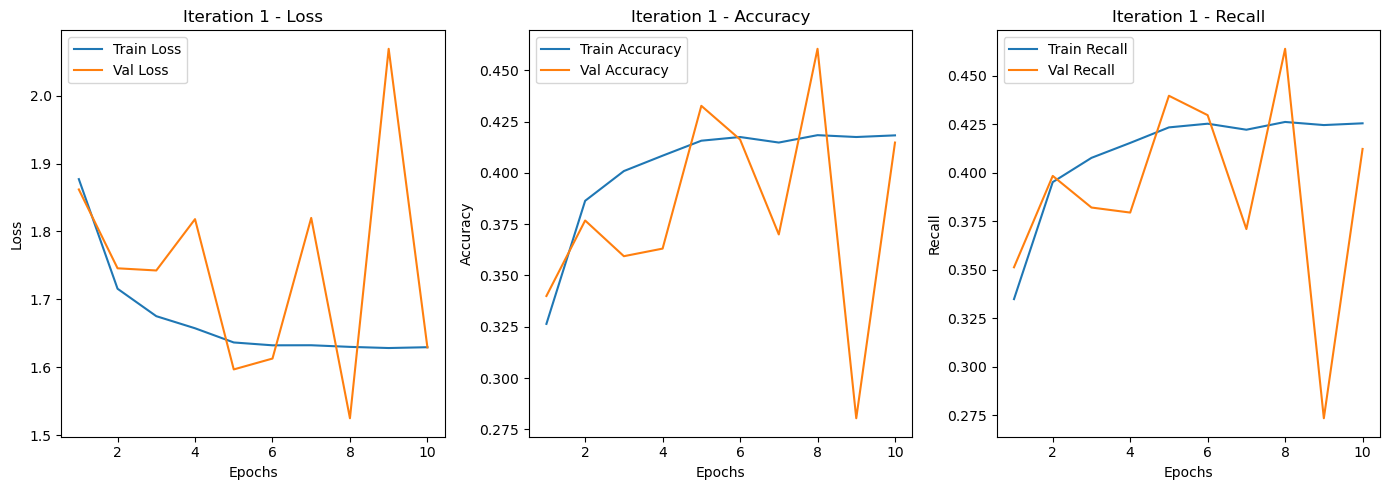

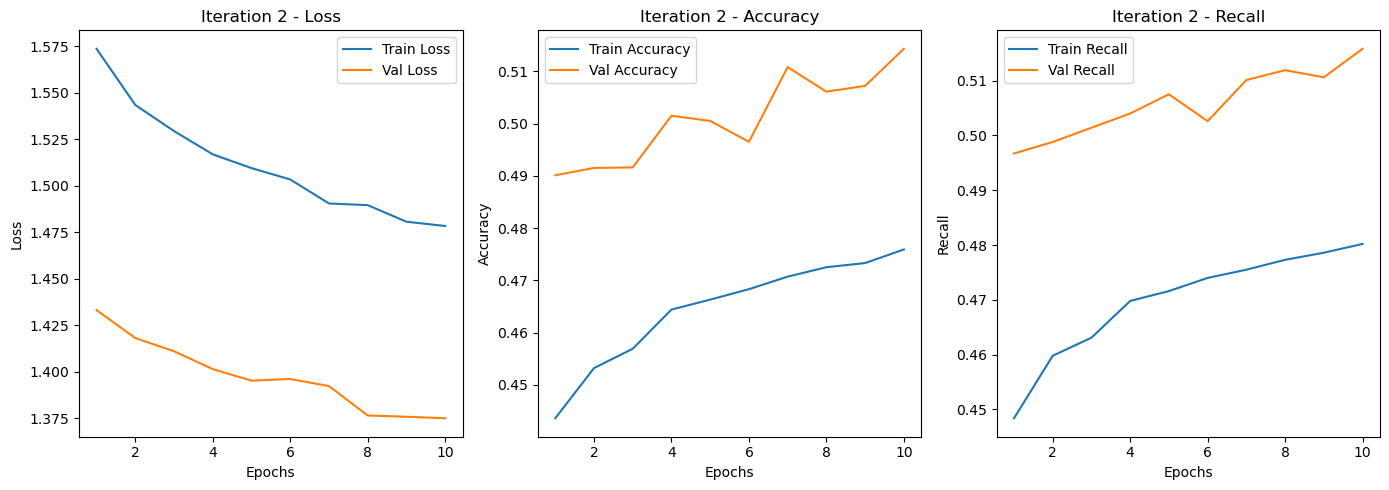

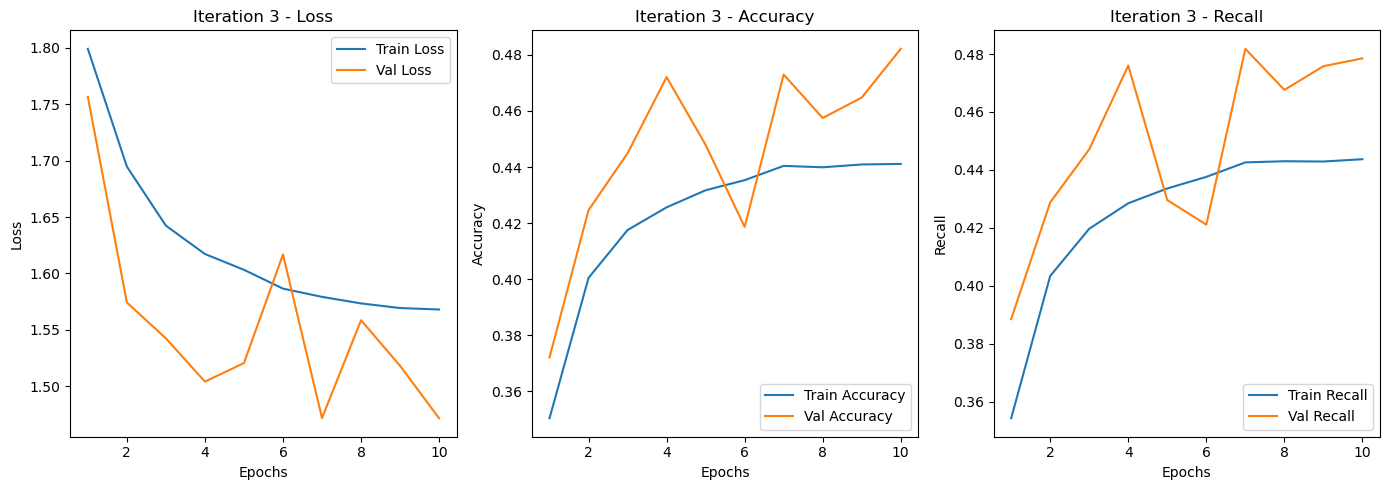

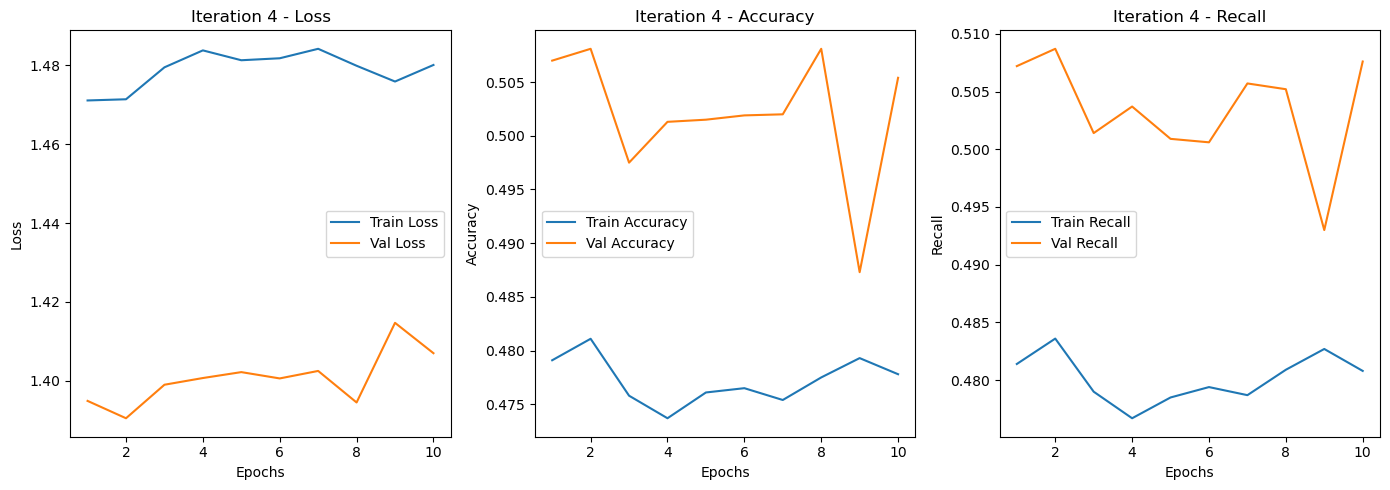

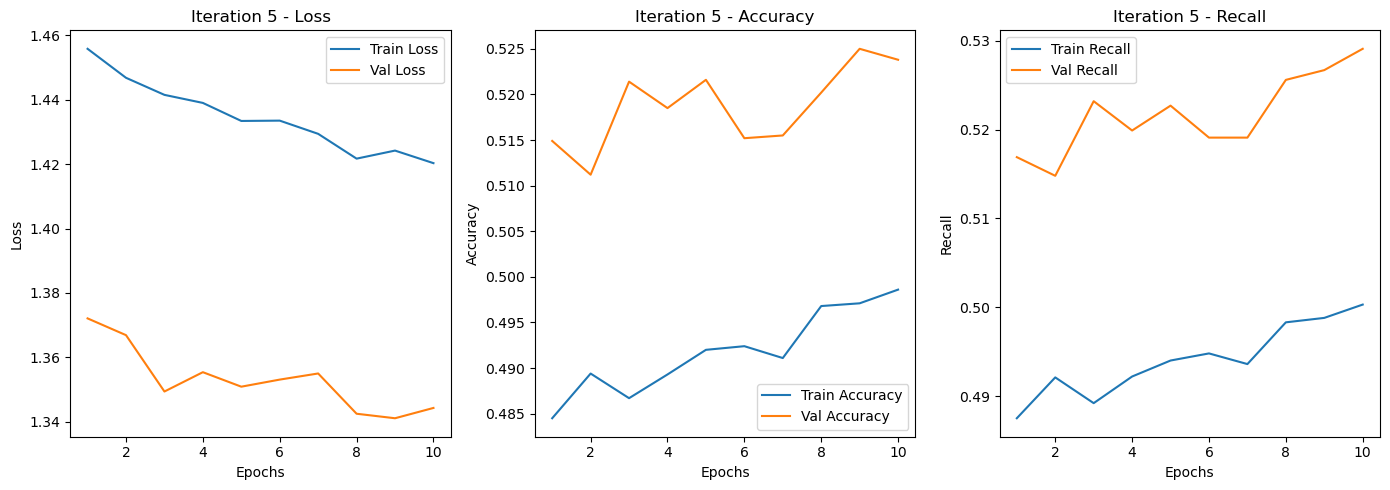

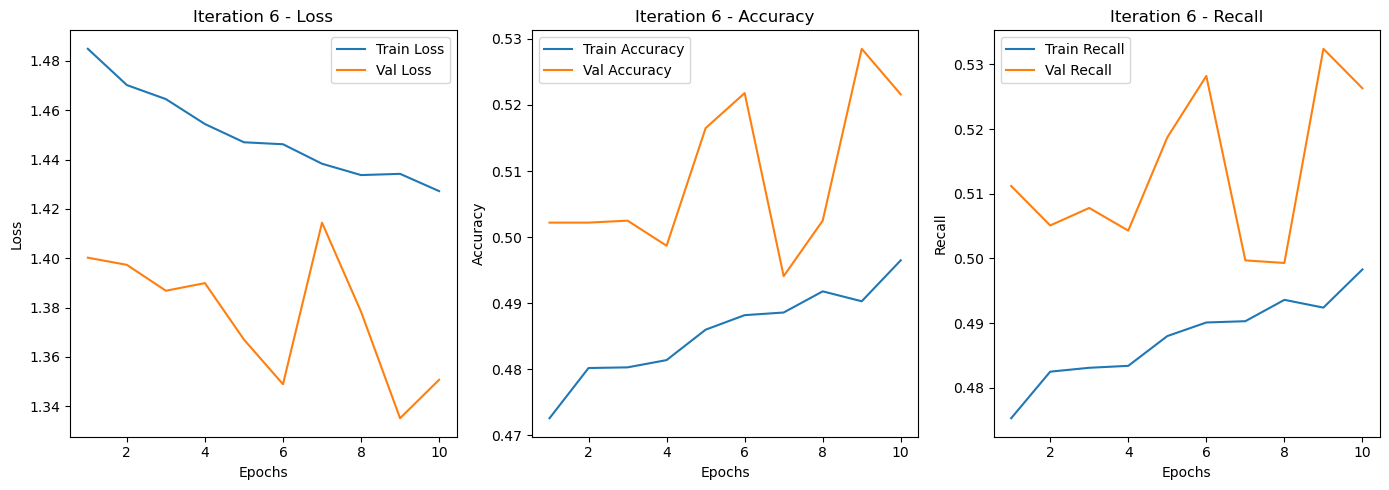

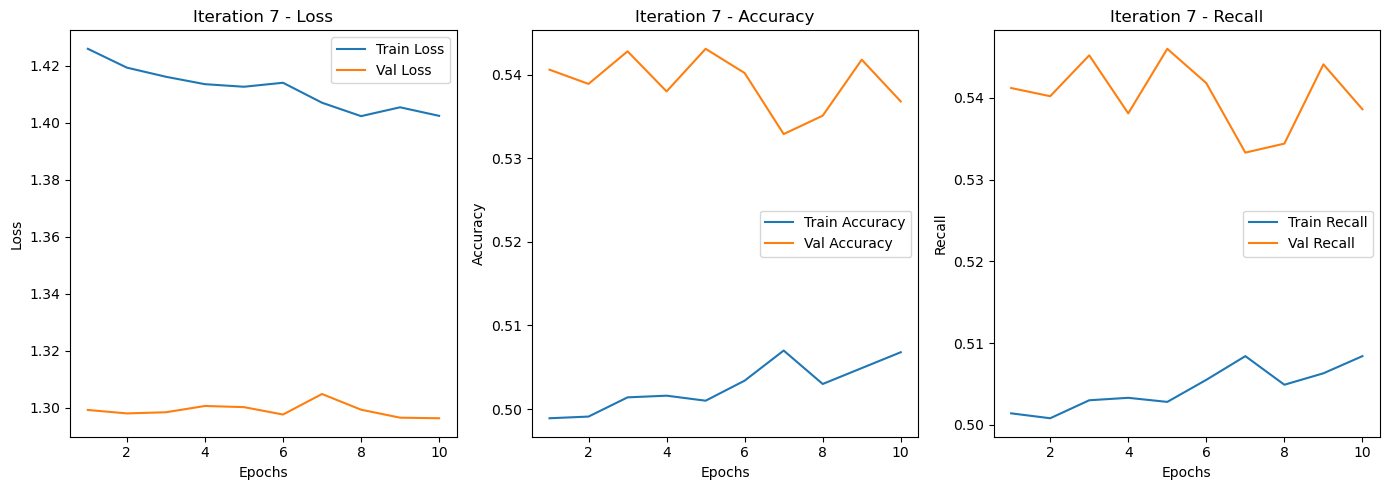

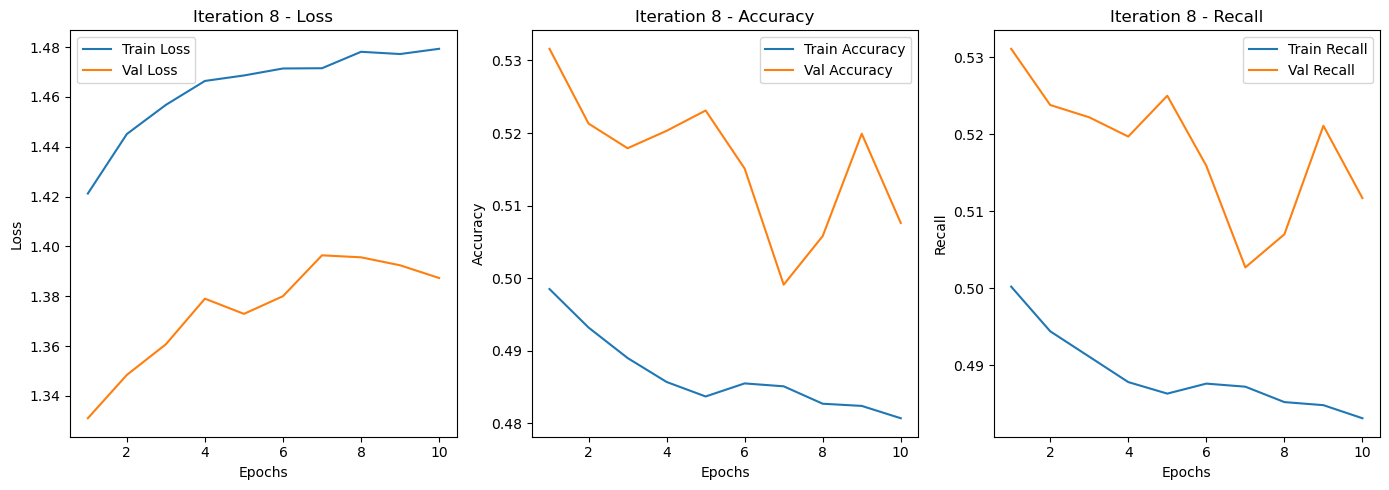

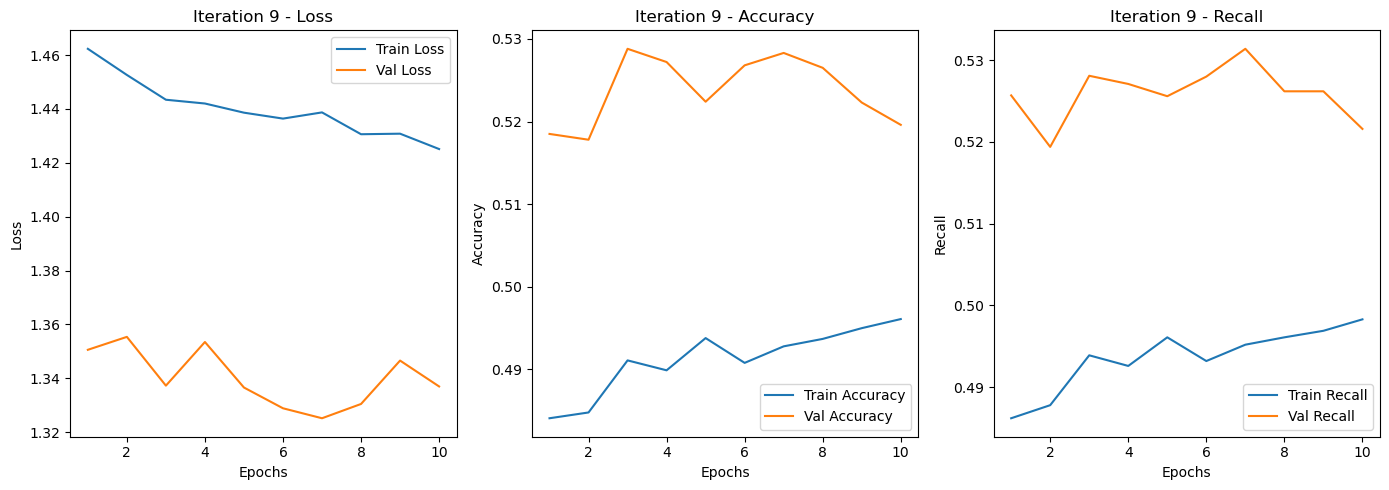

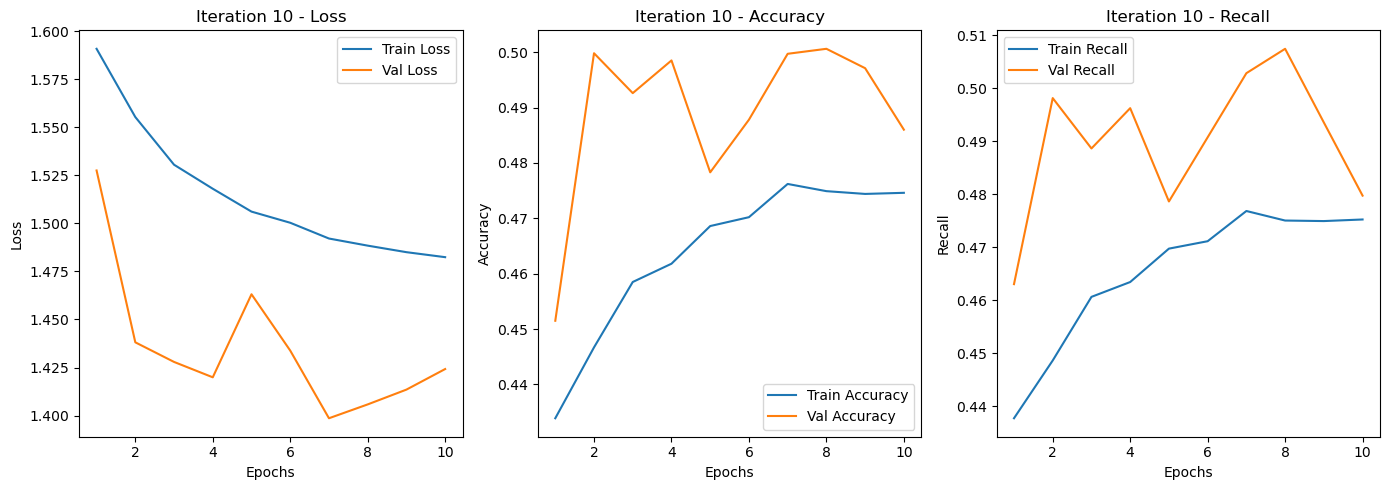

In [16]:
import matplotlib.pyplot as plt

# 이터레이션 데이터
iterations = [
    {
        "train_loss": [1.8771, 1.7157, 1.6753, 1.6575, 1.6366, 1.6324, 1.6325, 1.6301, 1.6284, 1.6296],
        "val_loss": [1.8619, 1.7458, 1.7426, 1.8182, 1.5969, 1.6129, 1.8200, 1.5250, 2.0690, 1.6293],
        "train_acc": [0.3264, 0.3864, 0.4009, 0.4084, 0.4157, 0.4175, 0.4148, 0.4184, 0.4175, 0.4183],
        "val_acc": [0.3400, 0.3768, 0.3594, 0.3631, 0.4327, 0.4163, 0.3700, 0.4605, 0.2804, 0.4148],
        "train_recall": [0.3349, 0.3952, 0.4077, 0.4154, 0.4234, 0.4253, 0.4222, 0.4262, 0.4246, 0.4255],
        "val_recall": [0.3513, 0.3984, 0.3821, 0.3795, 0.4397, 0.4297, 0.3710, 0.4639, 0.2735, 0.4123]
    },
    {
        "train_loss": [1.5735, 1.5433, 1.5293, 1.5168, 1.5094, 1.5033, 1.4904, 1.4895, 1.4806, 1.4783],
        "val_loss": [1.4331, 1.4181, 1.4110, 1.4014, 1.3952, 1.3961, 1.3923, 1.3765, 1.3758, 1.3750],
        "train_acc": [0.4436, 0.4532, 0.4569, 0.4644, 0.4663, 0.4683, 0.4707, 0.4725, 0.4733, 0.4759],
        "val_acc": [0.4901, 0.4915, 0.4916, 0.5015, 0.5005, 0.4965, 0.5108, 0.5061, 0.5072, 0.5143],
        "train_recall": [0.4484, 0.4598, 0.4631, 0.4698, 0.4716, 0.4740, 0.4755, 0.4773, 0.4786, 0.4802],
        "val_recall": [0.4967, 0.4988, 0.5014, 0.5040, 0.5075, 0.5026, 0.5101, 0.5119, 0.5106, 0.5158]
    },
    {
        "train_loss": [1.7991, 1.6947, 1.6423, 1.6172, 1.6032, 1.5865, 1.5792, 1.5734, 1.5693, 1.5680],
        "val_loss": [1.7565, 1.5742, 1.5424, 1.5041, 1.5205, 1.6168, 1.4718, 1.5585, 1.5181, 1.4716],
        "train_acc": [0.3503, 0.4004, 0.4175, 0.4256, 0.4317, 0.4353, 0.4404, 0.4399, 0.4409, 0.4411],
        "val_acc": [0.3720, 0.4246, 0.4449, 0.4721, 0.4479, 0.4186, 0.4730, 0.4575, 0.4648, 0.4822],
        "train_recall": [0.3543, 0.4034, 0.4197, 0.4285, 0.4336, 0.4376, 0.4426, 0.4430, 0.4429, 0.4437],
        "val_recall": [0.3885, 0.4288, 0.4471, 0.4760, 0.4296, 0.4211, 0.4818, 0.4676, 0.4758, 0.4785]
    },
    {
        "train_loss": [1.4711, 1.4714, 1.4795, 1.4838, 1.4813, 1.4818, 1.4842, 1.4799, 1.4759, 1.4801],
        "val_loss": [1.3949, 1.3905, 1.3990, 1.4007, 1.4022, 1.4006, 1.4025, 1.3945, 1.4147, 1.4070],
        "train_acc": [0.4791, 0.4811, 0.4758, 0.4737, 0.4761, 0.4765, 0.4754, 0.4775, 0.4793, 0.4778],
        "val_acc": [0.5070, 0.5081, 0.4975, 0.5013, 0.5015, 0.5019, 0.5020, 0.5081, 0.4873, 0.5054],
        "train_recall": [0.4814, 0.4836, 0.4790, 0.4767, 0.4785, 0.4794, 0.4787, 0.4809, 0.4827, 0.4808],
        "val_recall": [0.5072, 0.5087, 0.5014, 0.5037, 0.5009, 0.5006, 0.5057, 0.5052, 0.4930, 0.5076]
    },
    {
        "train_loss": [1.4558, 1.4468, 1.4415, 1.4390, 1.4334, 1.4335, 1.4294, 1.4217, 1.4242, 1.4203],
        "val_loss": [1.3721, 1.3669, 1.3494, 1.3554, 1.3509, 1.3531, 1.3550, 1.3425, 1.3411, 1.3443],
        "train_acc": [0.4845, 0.4894, 0.4867, 0.4893, 0.4920, 0.4924, 0.4911, 0.4968, 0.4971, 0.4986],
        "val_acc": [0.5149, 0.5112, 0.5214, 0.5185, 0.5216, 0.5152, 0.5155, 0.5202, 0.5250, 0.5238],
        "train_recall": [0.4875, 0.4921, 0.4892, 0.4922, 0.4940, 0.4948, 0.4936, 0.4983, 0.4988, 0.5003],
        "val_recall": [0.5169, 0.5148, 0.5232, 0.5199, 0.5227, 0.5191, 0.5191, 0.5256, 0.5267, 0.5291]
    },

    {
        "train_loss": [1.4849, 1.4702, 1.4645, 1.4544, 1.4470, 1.4462, 1.4383, 1.4337, 1.4342, 1.4272],
        "val_loss": [1.4002, 1.3973, 1.3868, 1.3899, 1.3670, 1.3489, 1.4144, 1.3783, 1.3351, 1.3507],
        "train_acc": [0.4726, 0.4802, 0.4803, 0.4814, 0.4860, 0.4882, 0.4886, 0.4918, 0.4903, 0.4965],
        "val_acc": [0.5022, 0.5022, 0.5025, 0.4987, 0.5165, 0.5218, 0.4941, 0.5025, 0.5285, 0.5216],
        "train_recall": [0.4753, 0.4825, 0.4831, 0.4834, 0.4880, 0.4901, 0.4903, 0.4936, 0.4924, 0.4983],
        "val_recall": [0.5112, 0.5051, 0.5078, 0.5043, 0.5187, 0.5282, 0.4997, 0.4993, 0.5324, 0.5263]
    },
 

# Iteration 6 데이터
    {
        "train_loss": [1.4259, 1.4193, 1.4161, 1.4135, 1.4126, 1.4140, 1.4070, 1.4023, 1.4054, 1.4024],
        "val_loss": [1.2993, 1.2981, 1.2985, 1.3007, 1.3003, 1.2977, 1.3049, 1.2994, 1.2966, 1.2964],
        "train_acc": [0.4989, 0.4991, 0.5014, 0.5016, 0.5010, 0.5034, 0.5070, 0.5030, 0.5049, 0.5068],
        "val_acc": [0.5406, 0.5389, 0.5428, 0.5380, 0.5431, 0.5402, 0.5329, 0.5351, 0.5418, 0.5368],
        "train_recall": [0.5014, 0.5008, 0.5030, 0.5033, 0.5028, 0.5055, 0.5084, 0.5049, 0.5063, 0.5084],
        "val_recall": [0.5412, 0.5402, 0.5452, 0.5381, 0.5460, 0.5418, 0.5333, 0.5344, 0.5441, 0.5386]
    },

    # Iteration 7 데이터
    {
        "train_loss": [1.4212, 1.4451, 1.4568, 1.4664, 1.4686, 1.4714, 1.4715, 1.4781, 1.4772, 1.4793],
        "val_loss": [1.3310, 1.3484, 1.3607, 1.3790, 1.3729, 1.3800, 1.3964, 1.3956, 1.3924, 1.3873],
        "train_acc": [0.4985, 0.4932, 0.4890, 0.4857, 0.4837, 0.4855, 0.4851, 0.4827, 0.4824, 0.4807],
        "val_acc": [0.5316, 0.5213, 0.5179, 0.5203, 0.5231, 0.5151, 0.4991, 0.5058, 0.5199, 0.5076],
        "train_recall": [0.5002, 0.4944, 0.4911, 0.4878, 0.4863, 0.4876, 0.4872, 0.4852, 0.4848, 0.4831],
        "val_recall": [0.5311, 0.5238, 0.5222, 0.5197, 0.5250, 0.5159, 0.5027, 0.5070, 0.5211, 0.5117]
    },

# Iteration 8 데이터
    {
        "train_loss": [1.4623, 1.4526, 1.4434, 1.4420, 1.4386, 1.4364, 1.4387, 1.4306, 1.4308, 1.4251],
        "val_loss": [1.3506, 1.3554, 1.3373, 1.3535, 1.3366, 1.3289, 1.3252, 1.3305, 1.3466, 1.3370],
        "train_acc": [0.4841, 0.4848, 0.4911, 0.4899, 0.4938, 0.4908, 0.4928, 0.4937, 0.4950, 0.4961],
        "val_acc": [0.5185, 0.5178, 0.5288, 0.5272, 0.5224, 0.5268, 0.5283, 0.5265, 0.5223, 0.5196],
        "train_recall": [0.4862, 0.4878, 0.4939, 0.4926, 0.4961, 0.4932, 0.4952, 0.4961, 0.4969, 0.4983],
        "val_recall": [0.5257, 0.5194, 0.5281, 0.5271, 0.5256, 0.5280, 0.5314, 0.5262, 0.5262, 0.5216]
    },

# Iteration 9 데이터
    {
        "train_loss": [1.5908, 1.5553, 1.5305, 1.5180, 1.5061, 1.5003, 1.4921, 1.4884, 1.4850, 1.4824],
        "val_loss": [1.5275, 1.4381, 1.4279, 1.4199, 1.4631, 1.4338, 1.3986, 1.4058, 1.4135, 1.4242],
        "train_acc": [0.4339, 0.4467, 0.4585, 0.4618, 0.4686, 0.4702, 0.4762, 0.4749, 0.4744, 0.4746],
        "val_acc": [0.4515, 0.4998, 0.4926, 0.4985, 0.4783, 0.4878, 0.4997, 0.5006, 0.4971, 0.4860],
        "train_recall": [0.4377, 0.4486, 0.4606, 0.4634, 0.4697, 0.4711, 0.4768, 0.4750, 0.4749, 0.4752],
        "val_recall": [0.4630, 0.4981, 0.4886, 0.4962, 0.4786, 0.4907, 0.5028, 0.5074, 0.4935, 0.4797]
    }
]
def plot_metrics(iterations):
    epochs = range(1, 11)
    for i, iteration in enumerate(iterations):
        plt.figure(figsize=(14, 5))
        # Loss plot
        plt.subplot(1, 3, 1)
        plt.plot(epochs, iteration["train_loss"], label="Train Loss")
        plt.plot(epochs, iteration["val_loss"], label="Val Loss")
        plt.title(f"Iteration {i+1} - Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        
        # Accuracy plot
        plt.subplot(1, 3, 2)
        plt.plot(epochs, iteration["train_acc"], label="Train Accuracy")
        plt.plot(epochs, iteration["val_acc"], label="Val Accuracy")
        plt.title(f"Iteration {i+1} - Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        
        # Recall plot
        plt.subplot(1, 3, 3)
        plt.plot(epochs, iteration["train_recall"], label="Train Recall")
        plt.plot(epochs, iteration["val_recall"], label="Val Recall")
        plt.title(f"Iteration {i+1} - Recall")
        plt.xlabel("Epochs")
        plt.ylabel("Recall")
        plt.legend()
        
        plt.tight_layout()
        plt.show()
plot_metrics(iterations)
